In [ ]:
import pandas as pd
import requests
import datetime
import matplotlib.pyplot as plt
import logging
import os
import numpy as np
import random
from tqdm.notebook import tqdm
from datetime import timedelta, datetime

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
pd.set_option('display.max_colwidth', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


#### Query 


In [ ]:
#bitQuery api token and set authorization
api_token = "BQYsxd6nKfXJeiZMCZrYA5fS5R1lnfAK"
block_chair_api_key = "G___ZVZodlVbyTWz7Jm8sJsJ2YHTTTpJ"
bitQuery_url = "https://graphql.bitquery.io"
headers = {'X-API-KEY': f'{api_token}'}

In [ ]:
def date_range(start, end, intv):
    offset = lambda x: (x[0]-one_day,x[1])
    format_range = lambda x: (x[0].strftime("%Y-%m-%d"),x[1].strftime("%Y-%m-%d"))
    start = datetime.strptime(start,"%Y-%m-%d")
    end = datetime.strptime(end,"%Y-%m-%d")
    one_day = timedelta(days=1)
    diff = (end  - start ) / intv
    if intv == 1:
        return format_range(offset((start,end+one_day)))
    range_list = []
    range_list.append((start, (start + diff)))
    for i in range(0,intv-2):
      range_list.append((range_list[-1][1],(range_list[-1][1] + (diff))))
    range_list.append((range_list[-1][1], end + one_day))
    return [format_range(offset(x)) for x in range_list]

In [ ]:
def get_transfers_from_address(address, after_date, before_date, chunks=1):
  logging.basicConfig(level=logging.DEBUG)
  s = requests.Session()
  retries = Retry(total=5, backoff_factor=1, status_forcelist=[ 502, 503, 504 ], method_whitelist=False)
  s.mount('https://', HTTPAdapter(max_retries=retries))
  query = """
  query ($address: String!, $after: ISO8601DateTime, $before: ISO8601DateTime) {
    bitcoin {
      coinpath(
        date: {after: $after, before: $before}
        initialAddress: {is: $address}
        depth: {lteq: 1}
        options: {asc: "block.timestamp.iso8601", desc: "amount"}
      ) {
        receiver {
          address
        }
        amount
        block {
          timestamp {
            iso8601
          }
        }
        sender {
          address
        }
        transaction {
          hash
        }
      }
    }
  }
  """
  range_list = date_range(after_date, before_date, chunks)
  partitions = ( range_list if len(range_list) > 2 else [range_list])
  columns = ["receiver", "sender", "amount", "timestamp",	"hash"]
  full_df = pd.DataFrame(columns= columns)
  filter = lambda x: {"receiver": x["receiver"]["address"], "sender": x["sender"]["address"], "amount": x["amount"], "timestamp": x["block"]["timestamp"]["iso8601"], "hash": x["transaction"]["hash"] }
  for start, end in tqdm(partitions):
    try: 
        variables = {"address": address, "after":start, "before":end}
        r = s.post(url=bitQuery_url, json={'query': query, 'variables': variables}, headers=headers) #do the request
        try:
          r = r.json()
        except: 
          print(r.text)
        try:
          df = pd.DataFrame([filter(x) for x in r["data"]["bitcoin"]["coinpath"]])
          df['timestamp'] = pd.to_datetime(df['timestamp'])
          full_df = full_df.append(df, ignore_index=True)
        except:
          pass
    except requests.exceptions.HTTPError as errh:
      print ("Http Error:",errh)
    except requests.exceptions.ConnectionError as errc:
      print ("Error Connecting:",errc)
    except requests.exceptions.Timeout as errt:
      print ("Timeout Error:",errt)
    except requests.exceptions.RequestException as err:
      print ("OOps: Something Else",err)
  if full_df.empty:
    return None
  else:
    return full_df.sort_values(by='timestamp')


#### Looking at Antpool


In [ ]:
#the block rewards get mined to 1 and get sent to either 2 or 3 I think that address 3 is where they send their pool fees
antpool_1_df = get_transfers_from_address("12dRugNcdxK39288NjcDV4GX7rMsKCGn6B","2020-02-29","2020-04-01")
antpool_2_df = get_transfers_from_address("3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6","2020-02-29","2020-04-01")
antpool_3_df = get_transfers_from_address("3ETALgNAaAoe6tMdCSBESnBM9ExHT1f2fB","2020-02-29","2020-04-01")

In [ ]:
antpool_1_df

,receiver,sender,amount,hash
timestamp,,,,
2020-02-29 07:32:12+00:00,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,600.000000,ed5ab72ab3bf6c9231e58274e6ca612335d7d82ad2d2cd...
2020-02-29 07:32:12+00:00,,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,0.001438,ed5ab72ab3bf6c9231e58274e6ca612335d7d82ad2d2cd...
2020-03-02 04:00:03+00:00,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,450.000000,a3afe5a4ab77d6697db29f976a88a03a96c345824548dc...
2020-03-02 04:00:03+00:00,,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,0.000558,a3afe5a4ab77d6697db29f976a88a03a96c345824548dc...
2020-03-03 12:19:19+00:00,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,250.000000,af05266989fcf0e43909807a4a20411430d7cc88aa2d96...
2020-03-03 12:19:19+00:00,,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,0.000479,af05266989fcf0e43909807a4a20411430d7cc88aa2d96...
2020-03-05 07:56:30+00:00,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,400.000000,a8e5a5f81ae9131c13a80205e39bf27cd2505b5e2647e2...
2020-03-05 07:56:30+00:00,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,50.000000,f599235e487abc02767f3ce2e3379d34b8388ce02c13ca...
2020-03-05 07:56:30+00:00,,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,0.000765,a8e5a5f81ae9131c13a80205e39bf27cd2505b5e2647e2...


In [ ]:
antpool_2_df

,receiver,sender,amount,hash
timestamp,,,,
2020-03-01 01:17:33+00:00,bc1qyzj8yys93243cx9ka4tgsckfmw0d0s02j0s2qn,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,47.506630,d438829def5d7ef02b3ca53cf3825b2345637fa9ba9197...
2020-03-01 01:17:33+00:00,19nW7ZnGBiYFp5x2xD9PoWwWmubezktjQG,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,1.081539,d438829def5d7ef02b3ca53cf3825b2345637fa9ba9197...
2020-03-01 01:17:33+00:00,3QtLTfykT57mChQeT8ovycwzp1zjNwLbbV,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,0.208572,d438829def5d7ef02b3ca53cf3825b2345637fa9ba9197...
2020-03-01 01:17:33+00:00,3EWp8BhZngLzrwHLxmLMyarfNUvRriuiHH,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,0.115258,d438829def5d7ef02b3ca53cf3825b2345637fa9ba9197...
2020-03-01 01:17:33+00:00,1A5QoFFShVRv8BZnCA47F4FcNZ1D3757KJ,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,0.081581,d438829def5d7ef02b3ca53cf3825b2345637fa9ba9197...
...,...,...,...,...
2020-03-30 01:47:02+00:00,37ZEwwHc8NqRyp8FLecuc8itG1TCWhpzyF,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,0.001310,8ac0134d1f5a05af366476ba4095a6558c2b6993279baa...
2020-03-30 01:47:02+00:00,,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,0.000423,49dd23a85b5aa983ed738efdc11cf32d86bf97cb665ac3...
2020-03-30 01:47:02+00:00,,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,0.000037,8ac0134d1f5a05af366476ba4095a6558c2b6993279baa...


In [ ]:
antpool_3_df

,receiver,sender,amount,hash
timestamp,,,,
2020-03-01 01:25:41+00:00,3DdSjmY1AEUqTvQZ9G5iCNrZ91VTqyr6fT,3ETALgNAaAoe6tMdCSBESnBM9ExHT1f2fB,6.725612,35eecf0052843f4fb76aa6696bd8e70d06730200878a56...
2020-03-01 01:25:41+00:00,16Pyo64QNpXCMcrEsFsdr6rEVmszd64KXS,3ETALgNAaAoe6tMdCSBESnBM9ExHT1f2fB,0.001364,35eecf0052843f4fb76aa6696bd8e70d06730200878a56...
2020-03-01 01:25:41+00:00,,3ETALgNAaAoe6tMdCSBESnBM9ExHT1f2fB,0.000012,35eecf0052843f4fb76aa6696bd8e70d06730200878a56...
2020-03-03 01:24:34+00:00,382iq2n7WAWBX86ea1GxQmuPH6kL94UyHV,3ETALgNAaAoe6tMdCSBESnBM9ExHT1f2fB,7.339678,a62b1ce5583bceeba23efc9499d8ccca5449a43e1f4844...
2020-03-03 01:24:34+00:00,3QhTXMjvuAe2qPTM82c7ww8SZhMueKLXXC,3ETALgNAaAoe6tMdCSBESnBM9ExHT1f2fB,5.445878,b2f8ebd521b78ad631ddcd696b7fbe82c996d96db4ea86...
...,...,...,...,...
2020-03-29 01:27:46+00:00,,3ETALgNAaAoe6tMdCSBESnBM9ExHT1f2fB,0.000404,b0e93c62d7a7e484a9fcdfccd7fdaae5acb5a9956298b0...
2020-03-29 01:27:46+00:00,,3ETALgNAaAoe6tMdCSBESnBM9ExHT1f2fB,0.000023,23f0948af3d6699920ae9eeb8b1b8b46fa09fa3fc8b575...
2020-03-30 12:43:54+00:00,38dcNtF6M6AXtZAhCpuX5tCfqTyYHaKFtt,3ETALgNAaAoe6tMdCSBESnBM9ExHT1f2fB,21.073505,cc25325bb28a9ae793de79387d4dbc2b20221a7d608ed2...


In [ ]:
antpool_1_df_resampled =  antpool_1_df.resample("1D").sum()
antpool_2_df_resampled =  antpool_2_df.resample("1D").sum()
antpool_3_df_resampled =  antpool_3_df.resample("1D").sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


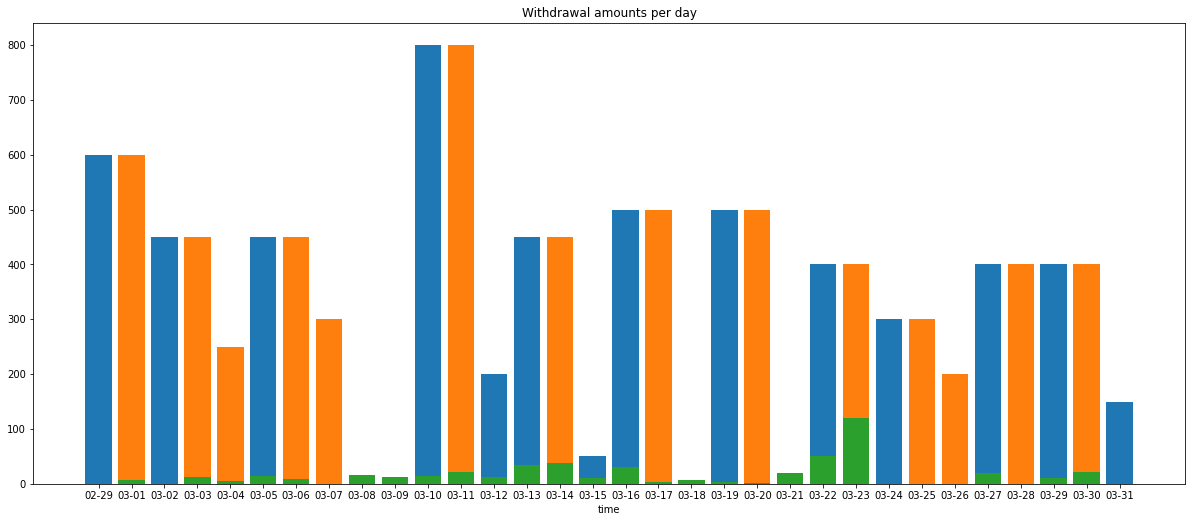

In [ ]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
ax2 =fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
ax3 =fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

ax.bar([x.strftime('%m-%d') for x in antpool_1_df_resampled.index],antpool_1_df_resampled["amount"], label="antpool 1") #blue
ax2.bar([x.strftime('%m-%d') for x in antpool_2_df_resampled.index],antpool_2_df_resampled["amount"],label="antpool 2") #orange
ax3.bar([x.strftime('%m-%d') for x in antpool_3_df_resampled.index],antpool_3_df_resampled["amount"],label="antpool 3") #


ax.set_xlabel("time")
ax.set_title('Withdrawal amounts per day')
plt.show()

# Getting data

### Antpool

In [ ]:
coinbase_txn_reciever = get_transfers_from_address("12dRugNcdxK39288NjcDV4GX7rMsKCGn6B","2018-01-01","2021-05-01")
coinbase_txn_reciever = coinbase_txn_reciever.loc[coinbase_txn_reciever["amount"] != 0]
coinbase_txn_reciever.drop_duplicates(inplace=True)
coinbase_txn_reciever.to_csv("/content/drive/MyDrive/Pool Tx Data/Antpool/hop 1/12dRugNcdxK39288NjcDV4GX7rMsKCGn6B.csv", index=False)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): graphql.bitquery.io:443
DEBUG:urllib3.connectionpool:https://graphql.bitquery.io:443 "POST / HTTP/1.1" 200 None


In [ ]:
coinbase_txn_reciever

,receiver,sender,amount,timestamp,hash
0,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,0.010000,2019-11-06 03:04:36+00:00,6dad492a25646e4168ba71058d88ccd1ce272539f48096515a8b3b3be052d554
1,,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,0.000072,2019-11-06 03:04:36+00:00,6dad492a25646e4168ba71058d88ccd1ce272539f48096515a8b3b3be052d554
2,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,300.000000,2019-11-09 01:57:17+00:00,c8dafc428e12c1243692cf4666e62180045b8aadeb474ee7cace51fe145b70a8
3,,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,0.001294,2019-11-09 01:57:17+00:00,c8dafc428e12c1243692cf4666e62180045b8aadeb474ee7cace51fe145b70a8
4,3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,250.000000,2019-11-11 02:33:23+00:00,b8391128488ba07a7e482f30bf9c8854a399c443cf3e1be46fcbabbb466fff88
...,...,...,...,...,...
670,1vhk5DCCuhmivHMuHmZLPP6bwkSf2TTzY,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,33.271490,2021-05-01 03:47:43+00:00,a4d5bf5183fe2be8a70ebab9222df197f2064c7d9188a5d9f4fa904a78a627e8
674,1vhk5DCCuhmivHMuHmZLPP6bwkSf2TTzY,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,0.862341,2021-05-01 08:38:35+00:00,152097cdd77a422ddb936d1e6cf039f5eed2e25c1e1887ac1d6ed06a09c81a8b
675,,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,0.000420,2021-05-01 08:38:35+00:00,152097cdd77a422ddb936d1e6cf039f5eed2e25c1e1887ac1d6ed06a09c81a8b
673,1vhk5DCCuhmivHMuHmZLPP6bwkSf2TTzY,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,3.559273,2021-05-01 08:38:35+00:00,3f279dc8d0234600957727c9f69e300ab536c4791ef7d3656f28f74c2c6a46e0


In [ ]:
recievers_of_coins = [x for x in coinbase_txn_reciever.receiver.unique() if x is not ""]
recievers_of_coins

['3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6',
 '3ETALgNAaAoe6tMdCSBESnBM9ExHT1f2fB',
 '391sdXqp97uraBaYm1S41uSCiN1vFt1TD2',
 'bc1qdtj4quduwq5zr4zvdamq8y92xfl5claqx29n0w',
 '13PphubHuZm9w64SCRguWAjGqfgbVNBE3J',
 '1vhk5DCCuhmivHMuHmZLPP6bwkSf2TTzY']

In [ ]:
addresses = {}
unobtainable_addresses = []
for address in tqdm(recievers_of_coins):
  coinbase_txn_reciever_txns = get_transfers_from_address(address,"2018-01-01","2021-05-01", chunks=4)
  if coinbase_txn_reciever_txns is not None:
    addresses[address] = coinbase_txn_reciever_txns
    coinbase_txn_reciever_txns.to_csv(f"/content/drive/MyDrive/Pool Tx Data/Antpool/hop 2/{address}.csv", index=False)
  else:
    print(f"Was not able to get address: {address}")
    unobtainable_addresses.append(address)
print(f"could not get addresses: {unobtainable_addresses}")

# Extracting features

In [ ]:
def extract_features(address):
  antpool_dist = pd.read_csv(f"/content/drive/MyDrive/Pool Tx Data/Antpool/hop 2/{address}.csv").dropna()
  mean = antpool_dist["amount"].mean()
  std = antpool_dist["amount"].std()
  antpool_dist["is_miner"] = 0
  print(f"The mean of all distributions is: {mean}\nThe std deviation is: {std}")
  antpool_dist.loc[(antpool_dist["amount"] < mean + std) & (antpool_dist["amount"] > mean - std),"is_miner"] = 1
  antpool_dist.to_csv(f"/content/drive/MyDrive/Pool Tx Data/Antpool/hop 2/features/probable miner transactions/{address}.csv", index=False)

  unique_miners = [address for address in antpool_dist["receiver"] if address is not ""]
  antpool_dist_miner_txns = antpool_dist.loc[(antpool_dist["receiver"].isin(unique_miners)) & (antpool_dist["is_miner"] == 1)].reset_index(drop=True)
  antpool_dist_miner_txns["timestamp"] = pd.to_datetime(antpool_dist_miner_txns.timestamp)

  features_df = antpool_dist_miner_txns.drop(["sender",	"amount",	"hash"], axis=1).groupby('receiver',).timestamp.agg(count='count', avg_time_diff= lambda group: group.sort_values().diff().mean(), first_seen=np.min, last_seen = np.max)
  features_df = pd.concat([features_df,antpool_dist_miner_txns.drop(["is_miner"], axis=1).groupby(["receiver"]).sum()], axis=1).rename(columns = {"amount": "total sent"})
  features_df['avg_time_diff'] = features_df['avg_time_diff'].fillna(pd.Timedelta(seconds=0))
  features_df["mean_tx_size"] = features_df["total sent"]/features_df["count"]
  features_df.reset_index(inplace=True)
  features_df.sort_values(["count","total sent","avg_time_diff"],ascending=[False,False, True], ignore_index=True,inplace=True)
  features_df.to_csv(f"/content/drive/MyDrive/Pool Tx Data/Antpool/hop 2/features/v2/{address}.csv", index=False)
  return features_df

In [ ]:
# def get_the_400(source_address, start, end, unobtainable_addresses=[]):
#   features_df = pd.read_csv(f"/content/drive/MyDrive/Pool Tx Data/Antpool/hop 2/features/v2/{source_address}.csv")
#   downloaded_addresses = [x.replace(".csv","") for x in os.listdir(f"/content/drive/MyDrive/Pool Tx Data/Antpool/hop 3/v2/{source_address}/") if x.endswith(".csv")]
#   print(len(downloaded_addresses))
#   hop_3_addresses = [x for x in features_df["receiver"] if x not in downloaded_addresses and x not in unobtainable_addresses][0:400]
#   undownloaded_addresses = [x for x in hop_3_addresses if x not in downloaded_addresses]
#   for address in tqdm(undownloaded_addresses):
#     if len(downloaded_addresses) <= 400:
#       result = get_transfers_from_address(address,start,end, chunks=5)
#       if result is not None:
#         result.to_csv(f"/content/drive/MyDrive/Pool Tx Data/Antpool/hop 3/v2/{source_address}/{address}.csv", index=False)
#         downloaded_addresses.append(address)
#       else:
#         print(f"Was not able to get address: {address}")
#         unobtainable_addresses.append(address)
#     else:
#       return []
#   return unobtainable_addresses


In [ ]:
def get_transactions(source_address, start, end, unobtainable_addresses=[], limit=400):
  features_df = pd.read_csv(f"/content/drive/MyDrive/Pool Tx Data/Antpool/hop 2/features/v2/{source_address}.csv")
  downloaded_addresses = [x.replace(".csv","") for x in os.listdir(f"/content/drive/MyDrive/Pool Tx Data/Antpool/hop 3/v3/{source_address}/") if x.endswith(".csv")]
  print(len(downloaded_addresses))
  hop_3_addresses = [x for x in features_df["receiver"] if x not in downloaded_addresses and x not in unobtainable_addresses][0:limit]
  undownloaded_addresses = [x for x in hop_3_addresses if x not in downloaded_addresses]
  for address in tqdm(undownloaded_addresses):
    if len(downloaded_addresses) <= limit:
      result = get_transfers_from_address(address,start,end, chunks=5)
      if result is not None:
        result.to_csv(f"/content/drive/MyDrive/Pool Tx Data/Antpool/hop 3/v3/{source_address}/{address}.csv", index=False)
        downloaded_addresses.append(address)
      else:
        print(f"Was not able to get address: {address}")
        unobtainable_addresses.append(address)
    else:
      return []
  return unobtainable_addresses

#### 3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6 (OLD)

In [ ]:
extract_features("3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6")

The mean of all distributions is: 1.3432344386489172
The std deviation is: 9.694214463511464


,count,avg_time_diff,first_seen,last_seen,total sent,mean_tx_size
receiver,,,,,,
3Qhg12XeQVxvS1xxmaoszMkMxkjXpLeeMT,11,23 days 14:19:04.700000,2019-10-08 02:51:04+00:00,2020-05-31 02:01:51+00:00,42.176508,3.834228
13XWQ62ak1hQB3BvT9tGPDS8EWvGjL8a6A,63,4 days 11:59:14,2019-09-20 02:38:30+00:00,2020-06-25 01:50:58+00:00,35.425427,0.562308
3B3gZX7Xd3RuBRFVcFkLe9ZKs7xMu1zjAz,11,25 days 11:59:20.400000,2019-10-08 02:51:04+00:00,2020-06-19 02:44:28+00:00,29.458366,2.678033
16peVP3fXJK4dWfEjTi8RNs7HrhSUzEYvG,12,23 days 04:21:13.090909091,2019-10-08 02:51:04+00:00,2020-06-19 02:44:28+00:00,26.930028,2.244169
1EUiwgfDfyrdf3YdkrNVHL5MzwVCGvKQmm,14,20 days 11:03:33.230769230,2019-10-08 02:51:04+00:00,2020-06-30 02:37:16+00:00,26.827781,1.916270
...,...,...,...,...,...,...
1JnnN2ZokZP3j9WXDAw7yJ9J6T9eusmGjC,1,0 days 00:00:00,2019-12-03 02:46:59+00:00,2019-12-03 02:46:59+00:00,0.000140,0.000140
3DEc45BvDfTYEd2AeQ2wc1FgP1i5dbUn61,1,0 days 00:00:00,2020-06-10 03:04:00+00:00,2020-06-10 03:04:00+00:00,0.000084,0.000084
13NkRFAt26kBbWc6VuKUTM4kdb5NPqouUW,1,0 days 00:00:00,2019-10-15 02:18:35+00:00,2019-10-15 02:18:35+00:00,0.000077,0.000077


##### Get txn data for 400 Miners from the List of Unique miners.

(dont use coinbase txns stop after july 2020)

In [ ]:
unobtainables = get_the_400("3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6", "2020-11-20","2021-05-01")
get_the_400("3MzqqLdsYA7mL7re49JMLHJUjbFQ5RHHc6","2020-11-20","2021-05-01",unobtainables)

#### bc1qdtj4quduwq5zr4zvdamq8y92xfl5claqx29n0w

In [ ]:
features = extract_features("bc1qdtj4quduwq5zr4zvdamq8y92xfl5claqx29n0w")
features.loc[features["receiver"].isin(x for x in features["receiver"] if x.startswith("3ETAL"))]

The mean of all distributions is: 0.6329770752294211
The std deviation is: 5.6323855228186375


,receiver,count,avg_time_diff,first_seen,last_seen,total sent,mean_tx_size
2001,3ETALgNAaAoe6tMdCSBESnBM9ExHT1f2fB,6,19 days 04:58:53.400000,2020-09-07 02:09:00+00:00,2020-12-12 03:03:27+00:00,28.554803,4.759134


##### Get txn data for 400 Miners from the List of Unique miners.

In [ ]:
unobtainable_addresses = get_the_400("bc1qdtj4quduwq5zr4zvdamq8y92xfl5claqx29n0w","2020-11-20","2021-05-01")

In [ ]:
get_the_400("bc1qdtj4quduwq5zr4zvdamq8y92xfl5claqx29n0w","2020-11-20","2021-05-01",unobtainables)

In [ ]:
ungettable_addresses = get_transactions("bc1qdtj4quduwq5zr4zvdamq8y92xfl5claqx29n0w","2020-11-20","2021-05-01", limit=1000)

1001


In [ ]:
ungettable_addresses

[]

#### 1vhk5DCCuhmivHMuHmZLPP6bwkSf2TTzY


In [ ]:
extract_features("1vhk5DCCuhmivHMuHmZLPP6bwkSf2TTzY")

The mean of all distributions is: 0.07063627951533777
The std deviation is: 0.45645806183739096


,count,avg_time_diff,first_seen,last_seen,total sent,mean_tx_size
receiver,,,,,,
1NjeZ9Z7wgfUADJimXjZiT5QGPGzhWoT9F,47,0 days 03:37:10.717391304,2021-04-24 10:26:03+00:00,2021-05-01 08:56:16+00:00,8.903132,0.189428
1MR4gqargobCTa6p1qHLyhUsH4MJpZFVbJ,21,0 days 08:21:25.300000,2021-04-24 10:26:03+00:00,2021-05-01 09:34:29+00:00,7.298881,0.347566
35Y2GsFGZshPEC6KxsJEKCY76o7Grn8JfV,26,0 days 06:38:42,2021-04-24 10:48:46+00:00,2021-05-01 08:56:16+00:00,7.066067,0.271772
17ayuoCjdMoEt8svqorhv5eQA5jWKWfuh6,24,0 days 07:13:22.173913043,2021-04-24 10:48:46+00:00,2021-05-01 08:56:16+00:00,6.198044,0.258252
1CnEbyUeRMjCCXKYNbjYDzZjvdzDhjruks,35,0 days 04:53:09.705882352,2021-04-24 10:48:46+00:00,2021-05-01 08:56:16+00:00,6.082623,0.173789
...,...,...,...,...,...,...
3JjBTuKiHj2TJnVkeNnUnn3wEr1feifvLJ,1,0 days 00:00:00,2021-04-28 08:01:36+00:00,2021-04-28 08:01:36+00:00,0.000327,0.000327
38ZodAgvNC75M6qnjCvmjz9p5gw1kburEW,1,0 days 00:00:00,2021-04-29 08:57:02+00:00,2021-04-29 08:57:02+00:00,0.000327,0.000327
3Pf8H7qCeA8HZK64ci8CEis8hNRhnjyUKn,1,0 days 00:00:00,2021-04-29 08:57:02+00:00,2021-04-29 08:57:02+00:00,0.000326,0.000326


##### Get txn data for 400 Miners from the List of Unique miners.

In [ ]:
unobtainables = get_the_400("1vhk5DCCuhmivHMuHmZLPP6bwkSf2TTzY","2020-11-20","2021-05-01")
get_the_400("1vhk5DCCuhmivHMuHmZLPP6bwkSf2TTzY","2020-11-20","2021-05-01",unobtainables)

#### Add price features

##### find the returns

In [ ]:
price_data = pd.read_csv("/content/drive/MyDrive/Price Data/FTX_BTCUSD_minute.csv")
price_data["timestamp"] = pd.to_datetime(price_data.timestamp).apply(lambda x: x.tz_localize(None))
price_data = price_data.set_index("timestamp")
timedeltas = [1, 5, 10,15,30, 60,120]
timedeltas = [pd.Timedelta(minutes=x) for x in timedeltas]

In [ ]:
for timestamp in tqdm(price_data.index):
  price0 = price_data.at[timestamp, "low"]
  for delta in timedeltas:
    try:
      price1 = price_data.at[(timestamp + delta), "low"]
      price_data.at[timestamp, f"delta t+{int(delta.seconds/60)}"] = (price1-price0) / price0
    except:
      price_data.at[timestamp, f"delta t+{int(delta.seconds/60)}"] = -1
for col in price_data.columns.tolist()[6:]:
  price_data = price_data.loc[price_data[col] != -1]
price_data.to_csv("/content/drive/MyDrive/Price Data/FTX_BTCUSD_minute_with_returns.csv")

##### compute the means

In [ ]:
price_data = pd.read_csv("/content/drive/MyDrive/Price Data/FTX_BTCUSD_minute_with_returns.csv")
price_data["timestamp"] = pd.to_datetime(price_data.timestamp).apply(lambda x: x.tz_localize(None).floor('T'))
price_data = price_data.set_index("timestamp")
price_data

,open,high,low,close,Volume BTC,Volume USD,delta t+1,delta t+5,delta t+10,delta t+15,delta t+30,delta t+60,delta t+120
timestamp,,,,,,,,,,,,,
2021-05-26 05:21:00,39290.0,39319.0,39273.0,39319.0,3.609536,141923.34630,0.000942,0.003361,0.002674,0.000815,0.001706,0.013011,0.028035
2021-05-26 05:20:00,39320.0,39326.0,39287.0,39290.0,16.360318,642796.89640,-0.000356,0.002113,0.002876,0.001527,0.000356,0.012574,0.027006
2021-05-26 05:19:00,39327.0,39364.0,39317.0,39321.0,1.385277,54470.48630,-0.000763,0.001348,0.003942,0.000331,0.000102,0.010759,0.025714
2021-05-26 05:18:00,39360.0,39361.0,39317.0,39327.0,0.723137,28438.80240,0.000000,0.001450,0.003841,0.000738,0.000382,0.012514,0.025511
2021-05-26 05:17:00,39374.0,39394.0,39358.0,39360.0,4.552148,179172.52740,-0.001042,-0.001220,0.001270,0.000965,-0.001474,0.010595,0.025459
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-20 02:48:00,17988.5,17990.0,17976.5,17982.0,0.546250,9822.67450,0.000250,0.001669,0.000167,0.000473,0.002420,0.000056,0.011348
2020-11-20 02:47:00,17981.5,17994.0,17981.5,17988.5,0.247258,4447.79240,-0.000278,0.000306,0.000056,0.001057,0.002197,-0.000222,0.013041
2020-11-20 02:46:00,17973.5,17981.5,17971.0,17981.5,0.233996,4207.60595,0.000584,0.000890,0.002003,0.000974,0.002782,0.000362,0.013995


In [ ]:
means = {}
std_devs = {}
for col in price_data.columns.tolist()[6:]:
  means[col] = price_data[col].mean()
  std_devs[col] = price_data[col].std()
return_calcs = pd.DataFrame([std_devs, means])
return_calcs

,delta t+1,delta t+5,delta t+10,delta t+15,delta t+30,delta t+60,delta t+120
0,0.001431,0.003525,0.004964,0.006044,0.008407,0.011321,0.015612
1,0.000003,0.000019,0.000037,0.000054,0.000105,0.000203,0.000393


In [ ]:
def get_features(df):
  df["timestamp"] = pd.to_datetime(df.timestamp).apply(lambda x: x.tz_localize(None).ceil('T')) #round the timestamps to the nearest min  
  features_df = df.drop(["receiver",	"amount",	"hash"], axis=1).groupby('sender',).timestamp.agg(count='count', avg_time_diff= lambda group: group.sort_values().diff().mean(), first_seen=np.min, last_seen = np.max)
  features_df['avg_time_diff'] = features_df['avg_time_diff'].fillna(pd.Timedelta(seconds=0))
  features_df['avg_tx_frequency/min'] = (features_df['count'] / ((features_df['last_seen'] - features_df['first_seen']).apply(lambda x: x.total_seconds()/60))).replace(np.inf, 0)
  features_df['total_sent'] =  df.drop(["receiver",	"timestamp",	"hash"], axis=1).groupby('sender').sum()
  features_df['avg_tx_volume/min'] = (features_df['total_sent'] / ((features_df['last_seen'] - features_df['first_seen']).apply(lambda x: x.total_seconds()/60))).replace(np.inf, 0)
  features_df["volume_mode"] = df.groupby('sender').agg(lambda x:x.value_counts().index[0])["amount"]

  # transactions_df.set_index(["timestamp"]) 
  # lower_bound = return_calcs.diff().dropna() #take the difference of the mean and the standard deviation (mean-std)
  return features_df.sort_values(by='sender')


In [ ]:
def combine_folder(folder):
  files = [x for x in os.listdir(folder) if x.endswith(".csv")]
  megaframe = pd.DataFrame(columns=["receiver","sender","amount","timestamp","hash"])
  for file in tqdm(files):
    megaframe = megaframe.append(pd.read_csv(f"{folder}/{file}"), ignore_index=True)
  return megaframe

In [ ]:
megaframe = combine_folder("/content/drive/MyDrive/Pool Tx Data/Antpool/hop 3/v3/bc1qdtj4quduwq5zr4zvdamq8y92xfl5claqx29n0w/")
megaframe.to_csv("/content/drive/MyDrive/Pool Tx Data/Antpool/hop 3/v3/aggregated_receiver_from_bc1qdtj4quduwq5zr4zvdamq8y92xfl5claqx29n0w.csv", index=False)

In [ ]:
features = get_features(pd.read_csv("/content/drive/MyDrive/Pool Tx Data/Antpool/hop 3/v3/aggregated_receiver_from_bc1qdtj4quduwq5zr4zvdamq8y92xfl5claqx29n0w.csv"))
features

,count,avg_time_diff,first_seen,last_seen,avg_tx_frequency/min,total_sent,avg_tx_volume/min,volume_mode
sender,,,,,,,,
112newSdxAgsTGSyn53iScFKaJBMNRh6qb,259,0 days 11:55:13.023255813,2020-12-23 06:48:00,2021-04-30 10:14:00,0.001404,0.642757,0.000003,0.000013
113uyH5gL2aRrsa9td2YPhKNxoEezgRiH5,150,0 days 12:14:52.751677852,2020-11-19 03:38:00,2021-02-03 04:35:00,0.001370,1.054988,0.000010,0.011733
114vAnqo7d2HsVdCLNJyA6Jq3wKaMNQak4,450,0 days 08:36:12.828507795,2020-11-19 19:24:00,2021-04-29 18:24:00,0.001941,1.264123,0.000005,0.000034
11gP5frWs6DDdZvKssNqNFHE9nmojm8XN,226,0 days 13:45:29.600000,2020-11-19 03:31:00,2021-03-28 03:07:00,0.001217,3.370756,0.000018,0.000019
1219LtRhShYUgit5EucGqB1CWXKi8ER7j1,40,0 days 18:27:38.461538461,2020-11-20 03:27:00,2020-12-20 03:25:00,0.000926,0.308029,0.000007,0.010807
...,...,...,...,...,...,...,...,...
bc1qt5cnvxmz6zyc9myd5akpzsycr66x35nzacalme,17,1 days 08:34:37.500000,2020-12-23 09:18:00,2021-01-14 02:32:00,0.000544,1.090530,0.000035,0.009486
bc1quev4kaaszdatddqnc53s6dktexnd44xwnrrdad,9,5 days 00:21:30,2021-03-17 14:34:00,2021-04-26 17:26:00,0.000156,14.704060,0.000255,0.024292
bc1qv376l9xexmcgztkwuqw4kfph6zj0l9hqe4ru4n,51,3 days 00:51:50.400000,2020-11-26 12:06:00,2021-04-27 07:18:00,0.000233,6.364367,0.000029,0.206917


In [ ]:
features.to_csv("/content/drive/MyDrive/Pool Tx Data/Antpool/hop 3/features/v3/receiver_from_bc1qdtj4quduwq5zr4zvdamq8y92xfl5claqx29n0w_averages_features_.csv")

In [ ]:
pd.read_csv("/content/drive/MyDrive/Pool Tx Data/Antpool/hop 3/features/v3/receiver_from_bc1qdtj4quduwq5zr4zvdamq8y92xfl5claqx29n0w_averages_features_.csv")

,sender,count,avg_time_diff,first_seen,last_seen,avg_tx_frequency/min,total_sent,avg_tx_volume/min,volume_mode
0,112newSdxAgsTGSyn53iScFKaJBMNRh6qb,259,0 days 11:55:13.023255813,2020-12-23 06:48:00,2021-04-30 10:14:00,0.001404,0.642757,0.000003,0.000013
1,113uyH5gL2aRrsa9td2YPhKNxoEezgRiH5,150,0 days 12:14:52.751677852,2020-11-19 03:38:00,2021-02-03 04:35:00,0.001370,1.054988,0.000010,0.011733
2,114vAnqo7d2HsVdCLNJyA6Jq3wKaMNQak4,450,0 days 08:36:12.828507795,2020-11-19 19:24:00,2021-04-29 18:24:00,0.001941,1.264123,0.000005,0.000034
3,11gP5frWs6DDdZvKssNqNFHE9nmojm8XN,226,0 days 13:45:29.600000,2020-11-19 03:31:00,2021-03-28 03:07:00,0.001217,3.370756,0.000018,0.000019
4,1219LtRhShYUgit5EucGqB1CWXKi8ER7j1,40,0 days 18:27:38.461538461,2020-11-20 03:27:00,2020-12-20 03:25:00,0.000926,0.308029,0.000007,0.010807
...,...,...,...,...,...,...,...,...,...
996,bc1qt5cnvxmz6zyc9myd5akpzsycr66x35nzacalme,17,1 days 08:34:37.500000,2020-12-23 09:18:00,2021-01-14 02:32:00,0.000544,1.090530,0.000035,0.009486
997,bc1quev4kaaszdatddqnc53s6dktexnd44xwnrrdad,9,5 days 00:21:30,2021-03-17 14:34:00,2021-04-26 17:26:00,0.000156,14.704060,0.000255,0.024292
998,bc1qv376l9xexmcgztkwuqw4kfph6zj0l9hqe4ru4n,51,3 days 00:51:50.400000,2020-11-26 12:06:00,2021-04-27 07:18:00,0.000233,6.364367,0.000029,0.206917
999,bc1qx20dyyk3jccq7uckmjs5j356e2z2zfpgtn0lt7,3,0 days 00:00:00,2021-04-17 23:52:00,2021-04-17 23:52:00,0.000000,0.096783,0.000000,0.094282


In [ ]:
 def flag_folder_of_txns(start_address):
  addresses = [x.replace(".csv","") for x in os.listdir(f"/content/drive/MyDrive/Pool Tx Data/Antpool/hop 3/v3/{start_address}/") if x.endswith(".csv")]
  columns = ["address", "delta t+1",	"delta t+5",	"delta t+10",	"delta t+15",	"delta t+30",	"delta t+60",	"delta t+120"] #create a zero-intitalized df of flagged txn counts
  txn_features = pd.DataFrame(columns=columns)
  for address in tqdm(addresses):
    df = flag_txns(f"/content/drive/MyDrive/Pool Tx Data/Antpool/hop 3/v3/{start_address}/{address}.csv")
    df["address"] = address
    txn_features = txn_features.append(df, ignore_index=True).sort_values(by='address')
  return txn_features

In [ ]:
# def flag_txns(file):
#   transactions_df = pd.read_csv(file).dropna() #get the file
#   transactions_df["timestamp"] = pd.to_datetime(transactions_df.timestamp).apply(lambda x: x.tz_localize(None).ceil('T')) #round the timestamps to the nearest min
#   transactions_df = transactions_df.loc[transactions_df["timestamp"].isin(price_data.index)] #only include transactions that we have price data for
#   transactions_df = transactions_df.set_index(["timestamp"])
#   transactions_df = transactions_df.drop(["receiver",	"sender",	"hash"], axis=1).groupby('timestamp').amount.agg(count='count', total_sent="sum")

#   target = return_calcs.diff().dropna() #take the difference of the mean and the standard deviation mean-std
#   columns = ["delta t+1",	"delta t+5",	"delta t+10",	"delta t+15",	"delta t+30",	"delta t+60",	"delta t+120"] #create a zero-intitalized df of flagged txn counts
#   flags_df = pd.DataFrame(columns = columns, index=[0])
#   flags_df.loc[0, columns] = [{"count":0,"volume":0}]*len(columns)

#   for timestamp in transactions_df.index: # for each timestamp get all the transacitons and the returns for that time. 
#     returns = price_data.loc[timestamp, columns]
#     for col in target.columns.tolist()[1:]:
#       if returns[col] < target.at[1,col]:
#         value = flags_df.at[0,col]
#         flags_df.at[0,col] = {"count": value["count"]+transactions_df.at[timestamp, "count"], "volume":value["volume"]+transactions_df.at[timestamp, "total_sent"]}
#   return flags_df
def flag_txns(file):
  transactions_df = pd.read_csv(file).dropna() #get the file
  transactions_df["timestamp"] = pd.to_datetime(transactions_df.timestamp).apply(lambda x: x.tz_localize(None).ceil('T')) #round the timestamps to the nearest min
  transactions_df = transactions_df.loc[transactions_df["timestamp"].isin(price_data.index)] #only include transactions that we have price data for
  transactions_df = transactions_df.set_index(["timestamp"])
  transactions_df = transactions_df.drop(["receiver",	"sender",	"hash"], axis=1).groupby('timestamp').amount.agg(count='count', total_sent="sum")

  target = return_calcs.diff().dropna() #take the difference of the mean and the standard deviation mean-std
  columns = ["delta t+1",	"delta t+5",	"delta t+10",	"delta t+15",	"delta t+30",	"delta t+60",	"delta t+120"] #create a zero-intitalized df of flagged txn counts
  flags_df = pd.DataFrame(columns = columns, index=[0])
  flags_df.loc[0, columns] = [{"count":0,"volume":0}]*len(columns)

  for timestamp in transactions_df.index: # for each timestamp get all the transacitons and the returns for that time. 
    returns = price_data.loc[timestamp, columns]
    for col in target.columns.tolist()[1:]:
      if returns[col] < target.at[1,col]:
        value = flags_df.at[0,col]
        flags_df.at[0,col] = {"count": value["count"]+1, "volume":value["volume"]+transactions_df.at[timestamp, "total_sent"]}
  return flags_df

In [ ]:
counts = flag_folder_of_txns("bc1qdtj4quduwq5zr4zvdamq8y92xfl5claqx29n0w")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
counts.to_csv("/content/drive/MyDrive/Pool Tx Data/Antpool/hop 3/features/v3/bc1qdtj4quduwq5zr4zvdamq8y92xfl5claqx29n0w_recievers_txns_features.csv", index=False)

In [ ]:
counts = pd.read_csv("/content/drive/MyDrive/Pool Tx Data/Antpool/hop 3/features/v3/bc1qdtj4quduwq5zr4zvdamq8y92xfl5claqx29n0w_recievers_txns_features.csv")
counts

,address,delta t+1,delta t+5,delta t+10,delta t+15,delta t+30,delta t+60,delta t+120
0,112newSdxAgsTGSyn53iScFKaJBMNRh6qb,"{'count': 0, 'volume': 0}","{'count': 4, 'volume': 0.021410060110110662}","{'count': 6, 'volume': 0.041358247286413435}","{'count': 6, 'volume': 0.03552572358280717}","{'count': 6, 'volume': 0.043658177723149276}","{'count': 6, 'volume': 0.0314927345514861}","{'count': 8, 'volume': 0.06412718696660093}"
1,113uyH5gL2aRrsa9td2YPhKNxoEezgRiH5,"{'count': 0, 'volume': 0}","{'count': 9, 'volume': 0.13205991115680585}","{'count': 5, 'volume': 0.07613872087060185}","{'count': 5, 'volume': 0.07352119834207059}","{'count': 6, 'volume': 0.09544530607603341}","{'count': 8, 'volume': 0.12151054044847785}","{'count': 7, 'volume': 0.10623366796107078}"
2,114vAnqo7d2HsVdCLNJyA6Jq3wKaMNQak4,"{'count': 0, 'volume': 0}","{'count': 13, 'volume': 0.09772250409358474}","{'count': 17, 'volume': 0.14620278257373526}","{'count': 12, 'volume': 0.09834772038503398}","{'count': 14, 'volume': 0.13279530139781875}","{'count': 14, 'volume': 0.10895973290663225}","{'count': 17, 'volume': 0.13946106222581092}"
3,11gP5frWs6DDdZvKssNqNFHE9nmojm8XN,"{'count': 0, 'volume': 0}","{'count': 9, 'volume': 0.2899768166911265}","{'count': 9, 'volume': 0.2813923977196437}","{'count': 7, 'volume': 0.21642162670337178}","{'count': 15, 'volume': 0.4423330040215524}","{'count': 15, 'volume': 0.46098412579754544}","{'count': 15, 'volume': 0.4651800199332873}"
4,1219LtRhShYUgit5EucGqB1CWXKi8ER7j1,"{'count': 0, 'volume': 0}","{'count': 2, 'volume': 0.030691004346410936}","{'count': 1, 'volume': 0.020433292291285748}","{'count': 2, 'volume': 0.030691004346410936}","{'count': 1, 'volume': 0.020433292291285748}","{'count': 1, 'volume': 0.020433292291285748}","{'count': 1, 'volume': 0.020433292291285748}"
...,...,...,...,...,...,...,...,...
996,bc1qt5cnvxmz6zyc9myd5akpzsycr66x35nzacalme,"{'count': 0, 'volume': 0}","{'count': 1, 'volume': 0.027972631646378678}","{'count': 1, 'volume': 0.027972631646378678}","{'count': 1, 'volume': 0.027972631646378678}","{'count': 0, 'volume': 0}","{'count': 0, 'volume': 0}","{'count': 1, 'volume': 0.027972631646378678}"
997,bc1quev4kaaszdatddqnc53s6dktexnd44xwnrrdad,"{'count': 0, 'volume': 0}","{'count': 0, 'volume': 0}","{'count': 0, 'volume': 0}","{'count': 0, 'volume': 0}","{'count': 1, 'volume': 1.0394861200000005}","{'count': 0, 'volume': 0}","{'count': 0, 'volume': 0}"
998,bc1qv376l9xexmcgztkwuqw4kfph6zj0l9hqe4ru4n,"{'count': 0, 'volume': 0}","{'count': 3, 'volume': 0.6166273499999987}","{'count': 3, 'volume': 0.5748346199999984}","{'count': 2, 'volume': 0.5414639199999968}","{'count': 1, 'volume': 0.2399524899999989}","{'count': 2, 'volume': 0.28074570999999776}","{'count': 4, 'volume': 0.8887179899999975}"
999,bc1qx20dyyk3jccq7uckmjs5j356e2z2zfpgtn0lt7,"{'count': 0, 'volume': 0}","{'count': 0, 'volume': 0}","{'count': 0, 'volume': 0}","{'count': 0, 'volume': 0}","{'count': 0, 'volume': 0}","{'count': 0, 'volume': 0}","{'count': 0, 'volume': 0}"
